In [183]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from tensorflow.keras.constraints import MaxNorm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
import sklearn.metrics as sm

In [184]:
dataBlocks = []
for num in range(1,112):
    df = pd.read_csv("dane/daily_dataset/daily_dataset/block_"+str(num)+".csv")
    dataBlocks.append(df)
data = pd.concat(dataBlocks, ignore_index=True)

In [185]:
data['date_time'] = pd.to_datetime(data['day'])
data['energy_sum'] = pd.to_numeric(data['energy_sum'], errors='coerce')
data = data.dropna(subset=['energy_sum'])
data['year'] = data['date_time'].apply(lambda x: x.year)
data['quarter'] = data['date_time'].apply(lambda x: x.quarter)
data['month'] = data['date_time'].apply(lambda x: x.month)
data['day'] = data['date_time'].apply(lambda x: x.day)
data = data.loc[:,['date_time','energy_sum', 'year','quarter','month','day']]
data.sort_values('date_time', inplace=True, ascending=True)
data = data.reset_index(drop=True)
data['weekday'] = data['date_time'].apply(lambda x: x.weekday() < 5).astype(int)

In [186]:
data.head()

,date_time,energy_sum,year,quarter,month,day,weekday
0,2011-11-23,1.283,2011,4,11,23,1
1,2011-11-23,7.408,2011,4,11,23,1
2,2011-11-23,3.036,2011,4,11,23,1
3,2011-11-23,5.619,2011,4,11,23,1
4,2011-11-23,5.798,2011,4,11,23,1


In [187]:
data.tail()

,date_time,energy_sum,year,quarter,month,day,weekday
3484824,2014-02-28,0.225,2014,1,2,28,1
3484825,2014-02-28,0.096,2014,1,2,28,1
3484826,2014-02-28,0.050,2014,1,2,28,1
3484827,2014-02-28,0.144,2014,1,2,28,1
3484828,2014-02-28,0.000,2014,1,2,28,1


In [188]:
print('Liczba wierszy i kolumn:', data.shape)
print('Najstarsza data:', data.date_time.min())
print('Najnowsza data:', data.date_time.max())

Liczba wierszy i kolumn: (3484829, 7)
Najstarsza data: 2011-11-23 00:00:00
Najnowsza data: 2014-02-28 00:00:00


In [189]:
energyPerDay = data.groupby('date_time')[['energy_sum']].sum()
data.drop_duplicates(subset=['date_time'], keep='first', inplace=True)
energyPerDay.reset_index()
data = data.merge(energyPerDay, on='date_time', how='left')
data.drop(['energy_sum_x'], inplace=True, axis=1)
data.rename(columns={'energy_sum_y':'energy_sum'}, inplace=True)

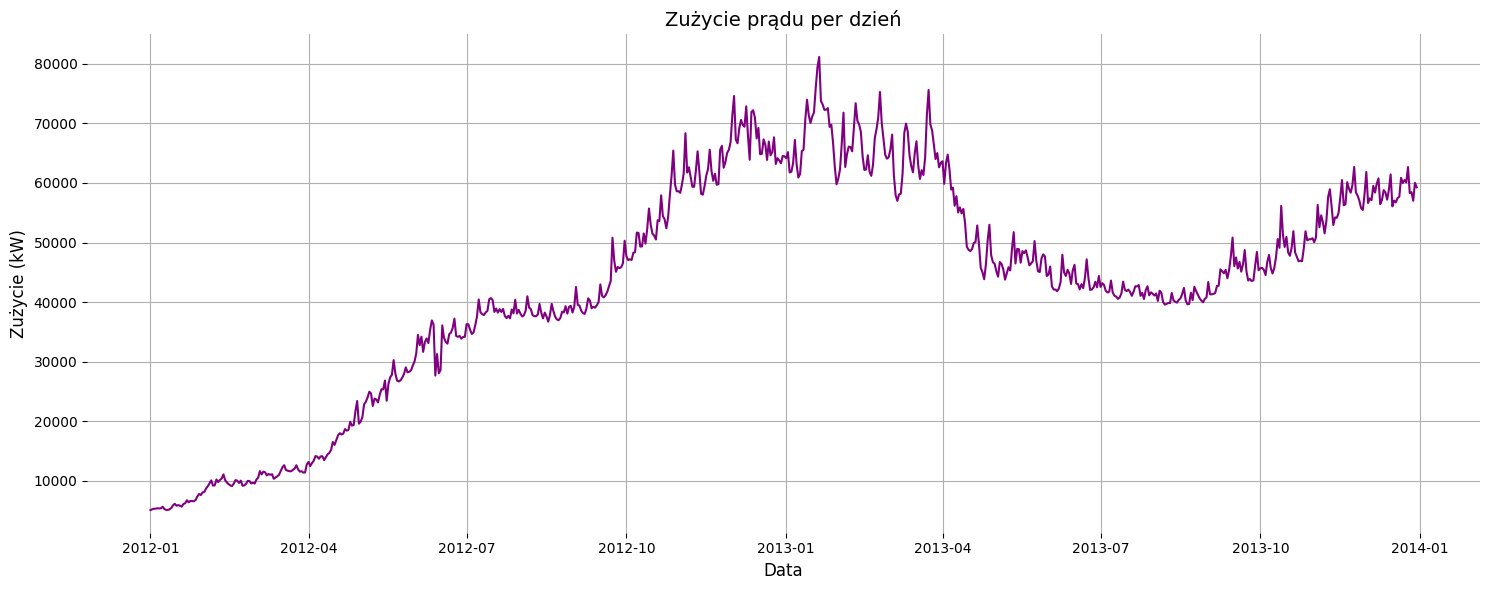

In [190]:
data_part = data[(data.date_time >= '2012-01-01') & (data.date_time < '2013-12-31')]

plt.figure(figsize=(15,6))
plt.plot(data_part.date_time, data_part.energy_sum, color='purple')
plt.ylabel('Zużycie (kW)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.title('Zużycie prądu per dzień', fontsize=14)
plt.tight_layout()
plt.grid(True)
sns.despine(bottom=True, left=True)
plt.show()

In [191]:
weather = pd.read_csv('dane/weather_daily_darksky.csv')
weather['date_time'] = pd.to_datetime(weather['time'])
weather['date_time'] = pd.to_datetime(weather['date_time'],format='%Y%m%d').dt.date
weather['date_time'] = weather["date_time"].astype("datetime64[ns]")
weather = weather[['date_time', 'temperatureMax',  'windSpeed', 'humidity', 'temperatureMin', 'uvIndex', 'cloudCover']]
weather = weather.dropna()
weather.head(4)

,date_time,temperatureMax,windSpeed,humidity,temperatureMin,uvIndex,cloudCover
0,2011-11-11,11.96,3.88,0.95,8.85,1.0,0.79
1,2011-12-11,8.59,3.94,0.88,2.48,1.0,0.56
2,2011-12-27,10.33,3.54,0.74,8.03,0.0,0.85
3,2011-12-02,8.07,3.00,0.87,2.56,1.0,0.32


In [192]:
data_with_weather = data.merge(weather, on='date_time')

In [193]:
data_with_weather.dropna()

,date_time,year,quarter,month,day,weekday,energy_sum,temperatureMax,windSpeed,humidity,temperatureMin,uvIndex,cloudCover
0,2011-11-23,2011,4,11,23,1,90.385000,10.36,2.04,0.93,3.81,1.0,0.36
1,2011-11-24,2011,4,11,24,1,213.412000,12.93,4.04,0.89,8.56,1.0,0.41
2,2011-11-25,2011,4,11,25,1,303.993000,13.03,5.02,0.79,7.46,1.0,0.48
3,2011-11-26,2011,4,11,26,0,420.976000,12.96,5.75,0.81,7.01,1.0,0.44
4,2011-11-27,2011,4,11,27,0,444.883001,13.54,5.48,0.72,4.47,1.0,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,2014-02-24,2014,1,2,24,1,51121.434004,14.23,5.02,0.74,7.99,1.0,0.50
824,2014-02-25,2014,1,2,25,1,50516.906004,11.43,5.69,0.78,6.79,1.0,0.62
825,2014-02-26,2014,1,2,26,1,50082.411995,11.29,3.82,0.73,4.17,2.0,0.26
826,2014-02-27,2014,1,2,27,1,50775.492997,10.31,4.14,0.74,3.93,2.0,0.32


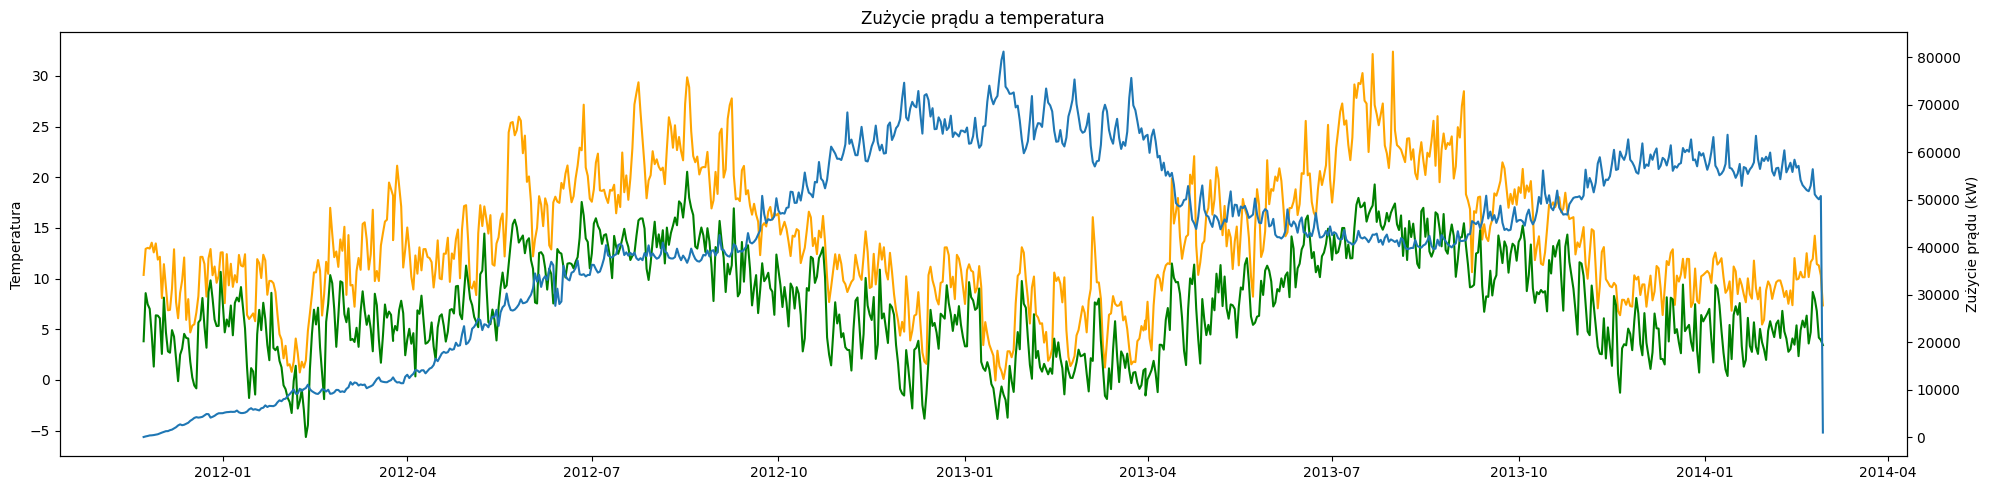

In [194]:
fig, ax1 = plt.subplots(figsize = (20, 5))
ax1.plot(data_with_weather["date_time"], data_with_weather["temperatureMax"], color="orange")
ax1.plot(data_with_weather["date_time"], data_with_weather["temperatureMin"], color="green")
ax1.set_ylabel("Temperatura")
ax2 = ax1.twinx()
ax2.plot(data_with_weather["date_time"], data_with_weather["energy_sum"], color = 'tab:blue')
ax2.set_ylabel("Zużycie prądu (kW)")
plt.title("Zużycie prądu a temperatura")
fig.tight_layout()
plt.show()

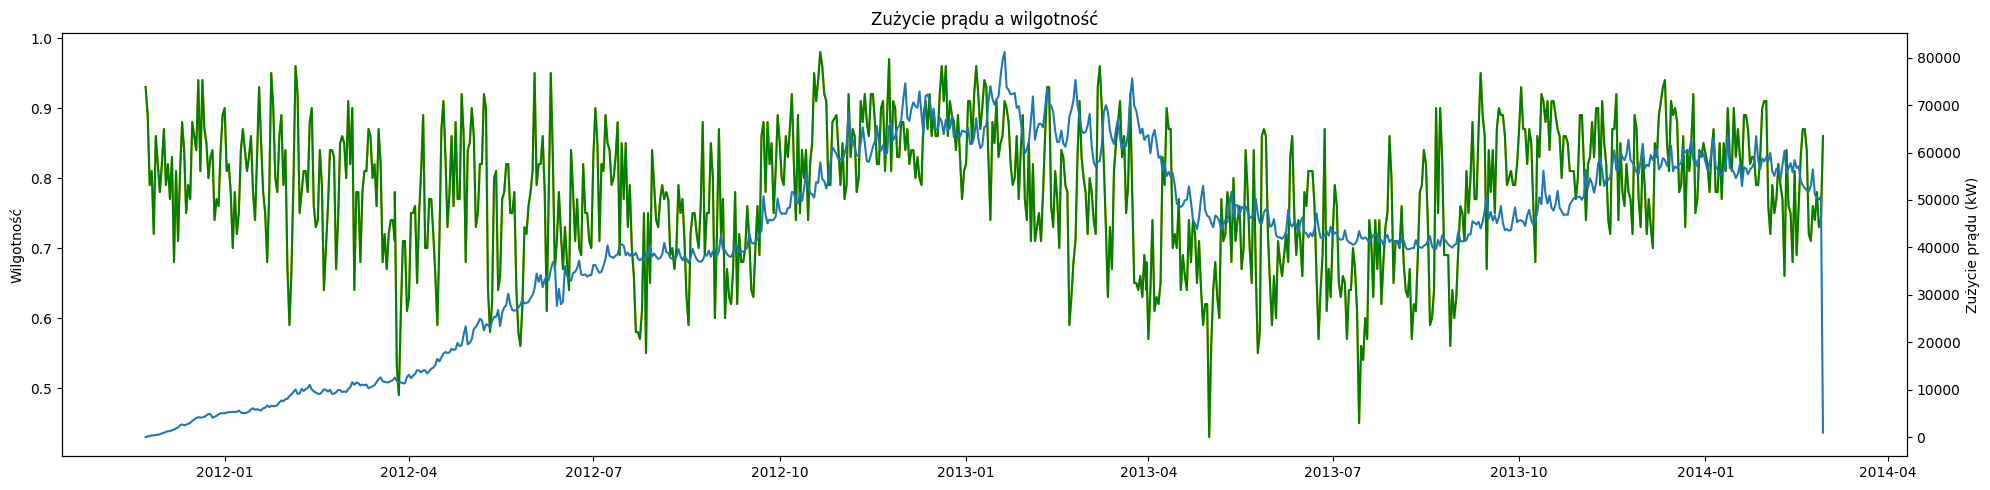

In [195]:
fig, ax1 = plt.subplots(figsize = (20, 5))
ax1.plot(data_with_weather["date_time"], data_with_weather["humidity"], color="orange")
ax1.plot(data_with_weather["date_time"], data_with_weather["humidity"], color="green")
ax1.set_ylabel("Wilgotność")
ax2 = ax1.twinx()
ax2.plot(data_with_weather["date_time"], data_with_weather["energy_sum"], color = 'tab:blue')
ax2.set_ylabel("Zużycie prądu (kW)")
plt.title("Zużycie prądu a wilgotność")
fig.tight_layout()
plt.show()

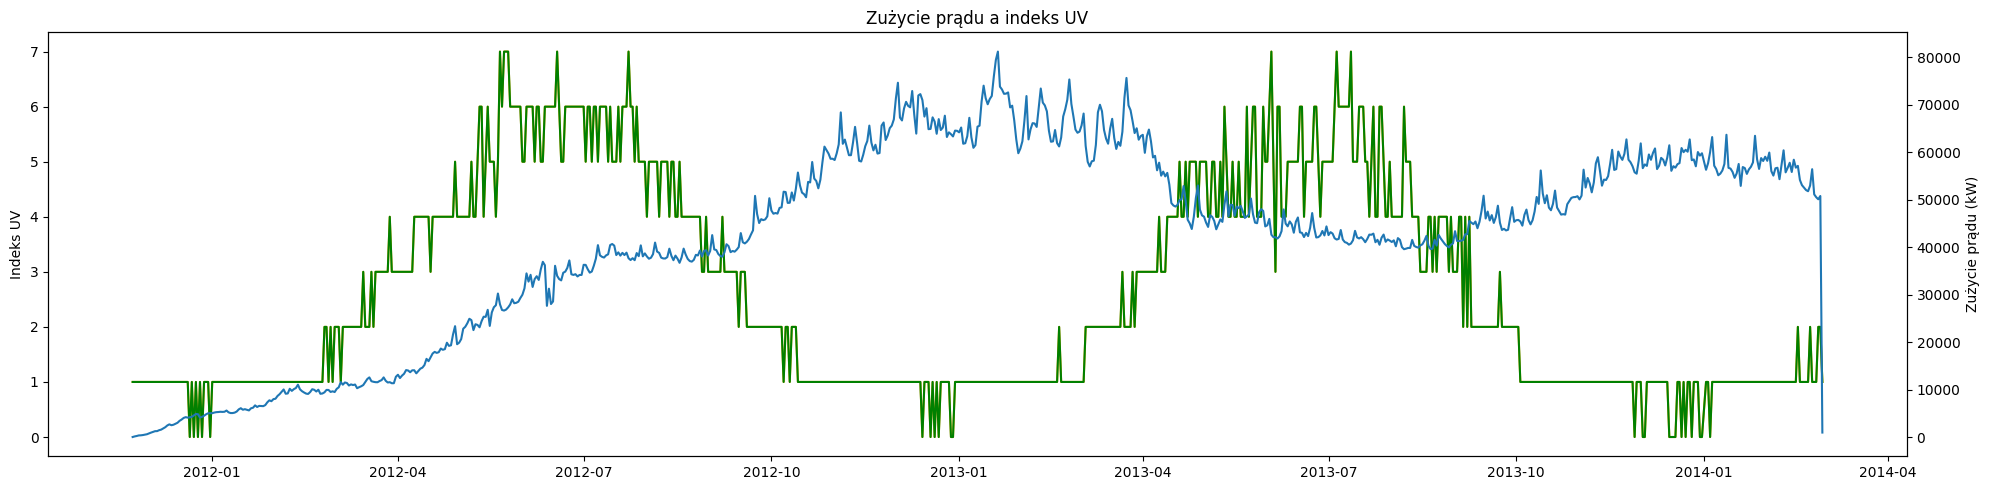

In [196]:
fig, ax1 = plt.subplots(figsize = (20, 5))
ax1.plot(data_with_weather["date_time"], data_with_weather["uvIndex"], color="orange")
ax1.plot(data_with_weather["date_time"], data_with_weather["uvIndex"], color="green")
ax1.set_ylabel("Indeks UV")
ax2 = ax1.twinx()
ax2.plot(data_with_weather["date_time"], data_with_weather["energy_sum"], color = 'tab:blue')
ax2.set_ylabel("Zużycie prądu (kW)")
plt.title("Zużycie prądu a indeks UV")
fig.tight_layout()
plt.show()

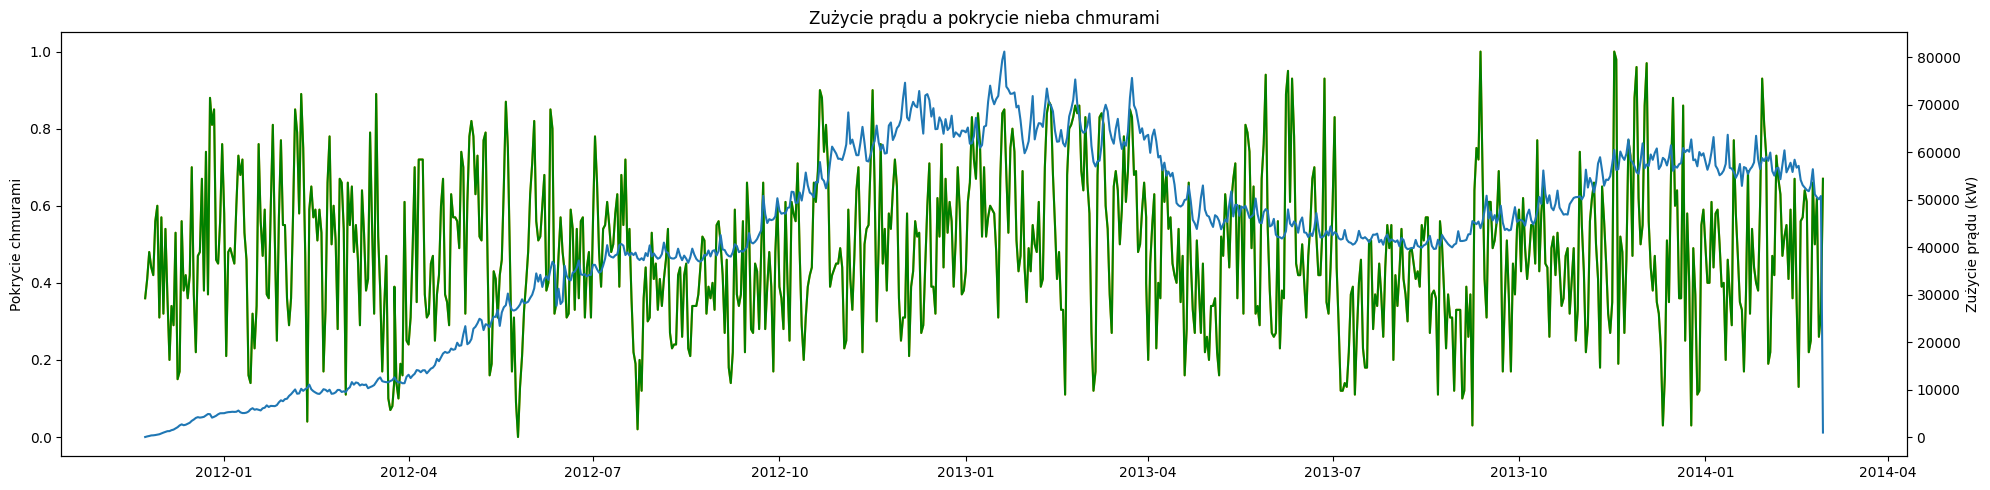

In [197]:
fig, ax1 = plt.subplots(figsize = (20, 5))
ax1.plot(data_with_weather["date_time"], data_with_weather["cloudCover"], color="orange")
ax1.plot(data_with_weather["date_time"], data_with_weather["cloudCover"], color="green")
ax1.set_ylabel("Pokrycie chmurami")
ax2 = ax1.twinx()
ax2.plot(data_with_weather["date_time"], data_with_weather["energy_sum"], color = 'tab:blue')
ax2.set_ylabel("Zużycie prądu (kW)")
plt.title("Zużycie prądu a pokrycie nieba chmurami")
fig.tight_layout()
plt.show()

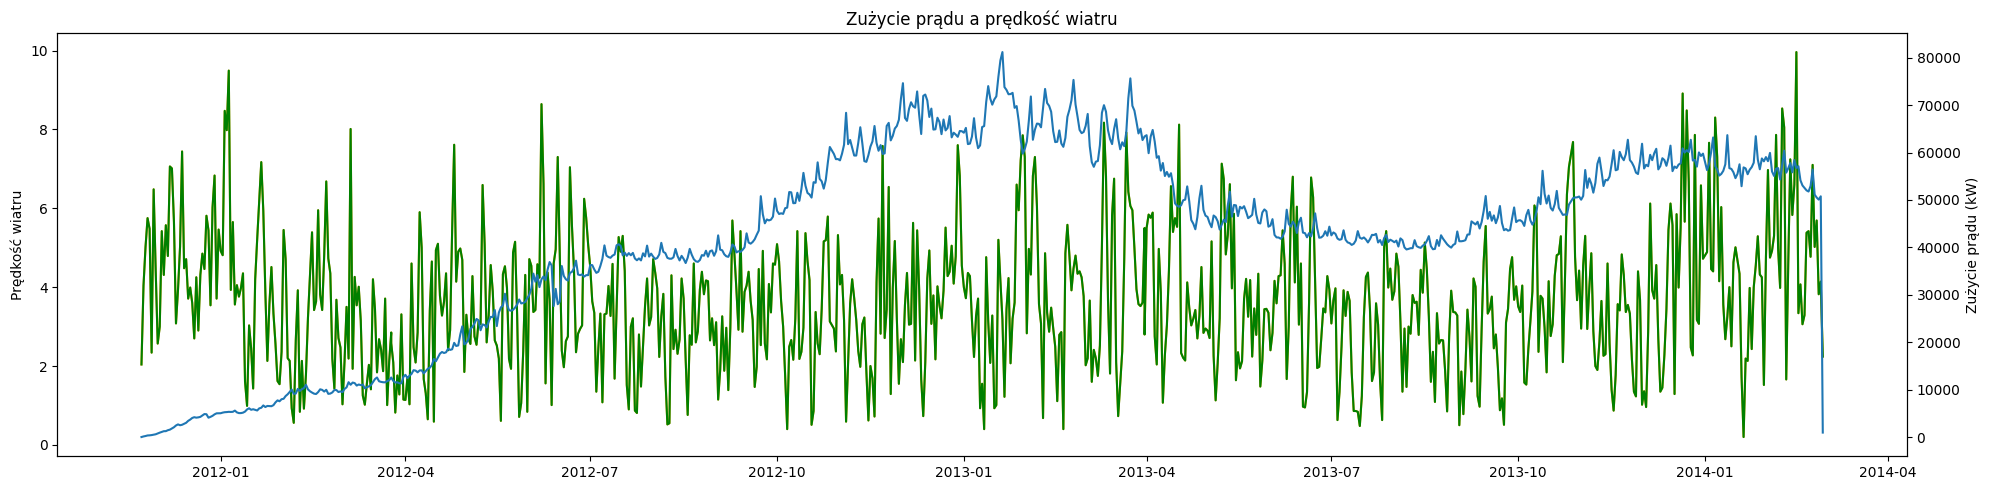

In [198]:
fig, ax1 = plt.subplots(figsize = (20, 5))
ax1.plot(data_with_weather["date_time"], data_with_weather["windSpeed"], color="orange")
ax1.plot(data_with_weather["date_time"], data_with_weather["windSpeed"], color="green")
ax1.set_ylabel("Prędkość wiatru")
ax2 = ax1.twinx()
ax2.plot(data_with_weather["date_time"], data_with_weather["energy_sum"], color = 'tab:blue')
ax2.set_ylabel("Zużycie prądu (kW)")
plt.title("Zużycie prądu a prędkość wiatru")
fig.tight_layout()
plt.show()

In [199]:
cor_matrix = data_with_weather[['energy_sum', 'temperatureMax', 'temperatureMin', 'cloudCover', 'windSpeed', 'humidity','uvIndex']].corr()
cor_matrix

,energy_sum,temperatureMax,temperatureMin,cloudCover,windSpeed,humidity,uvIndex
energy_sum,1.000000,-0.183176,-0.139281,0.124525,0.044194,0.132031,-0.187454
temperatureMax,-0.183176,1.000000,0.895553,-0.333409,-0.153602,-0.404899,0.696497
temperatureMin,-0.139281,0.895553,1.000000,-0.060703,-0.021707,-0.203930,0.598742
cloudCover,0.124525,-0.333409,-0.060703,1.000000,0.170235,0.480056,-0.248695
windSpeed,0.044194,-0.153602,-0.021707,0.170235,1.000000,-0.042391,-0.152634
humidity,0.132031,-0.404899,-0.203930,0.480056,-0.042391,1.000000,-0.533919
uvIndex,-0.187454,0.696497,0.598742,-0.248695,-0.152634,-0.533919,1.000000


In [200]:
scaler = MinMaxScaler()
data_with_weather_scaled = scaler.fit_transform(data_with_weather[['temperatureMax', 'temperatureMin', 'humidity', 'uvIndex', 'cloudCover']])

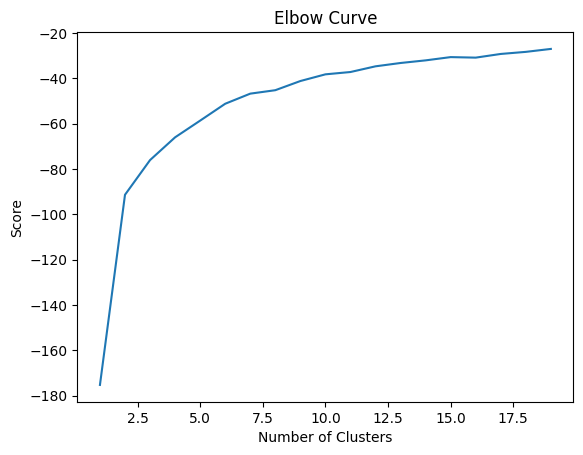

In [201]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(data_with_weather_scaled).score(data_with_weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [202]:
kmeans = KMeans(n_clusters=3, max_iter=600)
kmeans.fit(data_with_weather_scaled)
data_with_weather['weather_cluster'] = kmeans.labels_

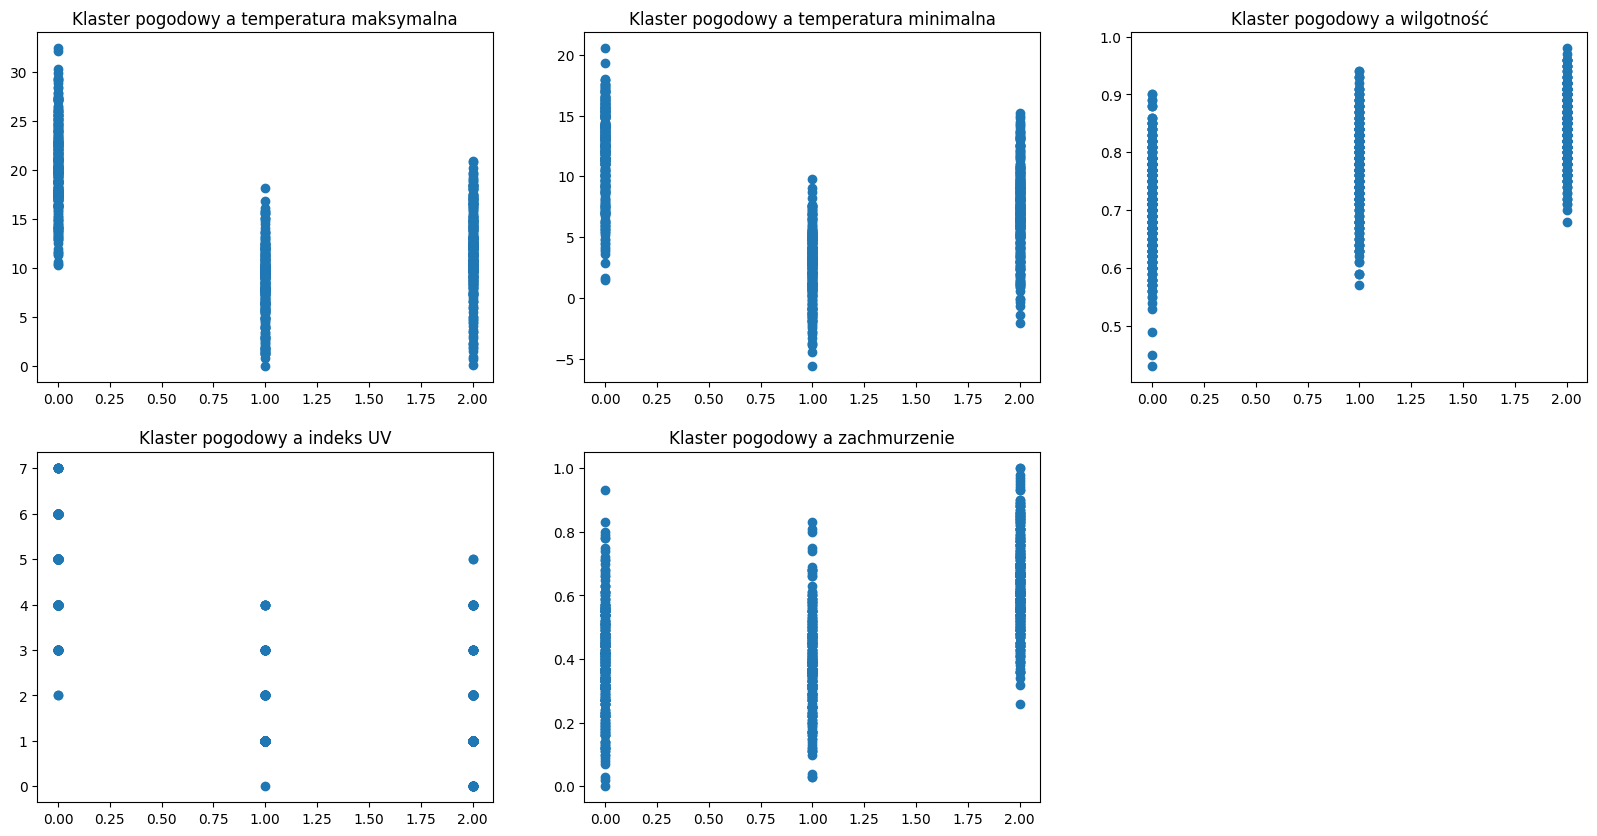

In [203]:
# Cluster Relationships with weather variables
plt.figure(figsize=(20,10))
plt.subplot(2, 3, 1)
plt.scatter(data_with_weather["weather_cluster"], data_with_weather["temperatureMax"])
plt.title('Klaster pogodowy a temperatura maksymalna')
plt.subplot(2, 3, 2)
plt.scatter(data_with_weather["weather_cluster"], data_with_weather["temperatureMin"])
plt.title('Klaster pogodowy a temperatura minimalna')
plt.subplot(2, 3, 3)
plt.scatter(data_with_weather["weather_cluster"], data_with_weather["humidity"])
plt.title('Klaster pogodowy a wilgotność')
plt.subplot(2, 3, 4)
plt.scatter(data_with_weather["weather_cluster"], data_with_weather["uvIndex"])
plt.title('Klaster pogodowy a indeks UV')
plt.subplot(2, 3, 5)
plt.scatter(data_with_weather["weather_cluster"], data_with_weather["cloudCover"])
plt.title('Klaster pogodowy a zachmurzenie')

plt.show()

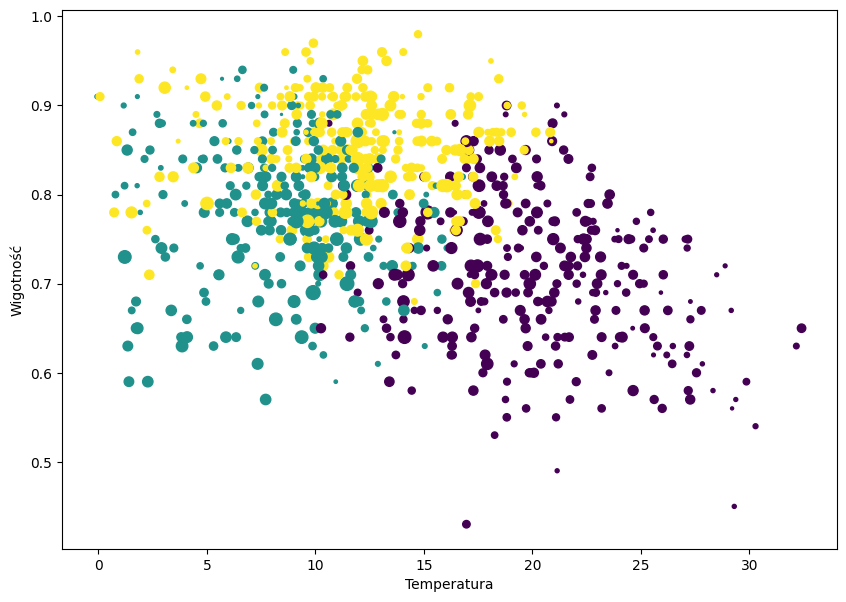

In [204]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(data_with_weather["temperatureMax"], 
            data_with_weather["humidity"], 
            s = data_with_weather["windSpeed"]*10,
            c = data_with_weather["weather_cluster"])
ax1.set_xlabel('Temperatura')
ax1.set_ylabel('Wigotność')
plt.show()

In [205]:
dataset = data_with_weather[['weather_cluster', 'weekday', 'energy_sum']]
dataset = dataset.values

In [206]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [207]:
X_train, Y_train = train[:, :-1], train[:, -1]
X_test, Y_test = test[:, :-1], test[:, -1]

In [208]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(579, 1, 2) (579,) (249, 1, 2) (249,)


In [209]:
model = Sequential()
model.add(LSTM(units=1000, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=500, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=500, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid', kernel_constraint=MaxNorm(3)))

#sgd = SGD(learning_rate=0.2, momentum=0.9)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='rmsprop')
#model.compile(loss=tf.keras.losses.MeanSquaredError(reduction="none"), optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=50, batch_size=50, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

c:\Users\3764\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 - 6s - 463ms/step - loss: 0.0736 - val_loss: 0.0232
Epoch 2/50
12/12 - 1s - 92ms/step - loss: 0.0733 - val_loss: 0.0233
Epoch 3/50
12/12 - 1s - 98ms/step - loss: 0.0733 - val_loss: 0.0234
Epoch 4/50
12/12 - 1s - 91ms/step - loss: 0.0732 - val_loss: 0.0234
Epoch 5/50
12/12 - 1s - 98ms/step - loss: 0.0732 - val_loss: 0.0235
Epoch 6/50
12/12 - 1s - 90ms/step - loss: 0.0732 - val_loss: 0.0235
Epoch 7/50
12/12 - 1s - 95ms/step - loss: 0.0732 - val_loss: 0.0235
Epoch 8/50
12/12 - 1s - 95ms/step - loss: 0.0732 - val_loss: 0.0236
Epoch 9/50
12/12 - 1s - 118ms/step - loss: 0.0732 - val_loss: 0.0236
Epoch 10/50
12/12 - 1s - 92ms/step - loss: 0.0732 - val_loss: 0.0237
Epoch 11/50
12/12 - 1s - 100ms/step - loss: 0.0732 - val_loss: 0.0237
Epoch 12/50
12/12 - 1s - 92ms/step - loss: 0.0732 - val_loss: 0.0237
Epoch 13/50
12/12 - 1s - 92ms/step - loss: 0.0732 - val_loss: 0.0237
Epoch 14/50
12/12 - 1s - 93ms/step - loss: 0.0732 - val_loss: 0.0238
Epoch 15/50
12/12 - 1s - 98ms/step - los

In [210]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 1, 1000)        │     4,012,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 1000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 1, 500)         │     3,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 500)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 1, 500)         │     2,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1, 500)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 100)            │       240,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,513,004 (70.62 MB)

 Trainable params: 9,256,501 (35.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,256,503 (35.31 MB)

In [211]:
train_predict = model.predict(X_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2])
train_predict = np.concatenate((train_predict, X_train), axis=1)
train_predict = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])
train_predict = np.concatenate((test_predict, X_test), axis=1)
train_predict = scaler.inverse_transform(train_predict)


print('Średni błąd bezwzględny na zbiorze testowym:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Pierwiastek z błędu średniokwadratowego na zbiorze testowym: ',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Średni błąd bezwzględny na zbiorze treningowym:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Pierwiastek z błędu średniokwadratowego na zbiorze testowym:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
print("Wynik R2 =", round(sm.r2_score(Y_test[0], test_predict[:,0]), 2))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


InvalidParameterError: The 'y_true' parameter of mean_absolute_error must be an array-like. Got 0.0 instead.

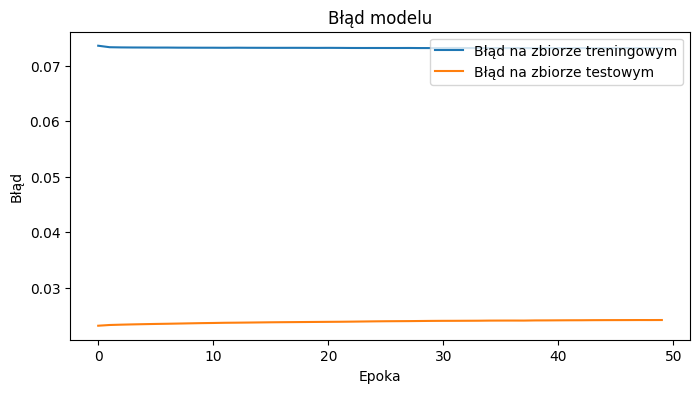

In [212]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Błąd na zbiorze treningowym')
plt.plot(history.history['val_loss'], label='Błąd na zbiorze testowym')
plt.title('Błąd modelu')
plt.ylabel('Błąd')
plt.xlabel('Epoka')
plt.legend(loc='upper right')
plt.show()

In [213]:
dni=[x for x in range(135)]
                    
plt.figure(figsize=(15,6))
plt.plot(dni, Y_test[0][:135], label="Realne zużycie", color='purple')
plt.plot(dni, test_predict[:,0][:135], label="Predykcja", color='red')
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Zużycie prądu (kW)', size=14)
plt.xlabel('Dni', size=14)
plt.legend(fontsize=16)
plt.show()

IndexError: invalid index to scalar variable.

<Figure size 1500x600 with 0 Axes>

In [214]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(0, len(Y_train[0][200:550])), Y_train[0][200:550], 'g', label="Historyczne dane zużycia prądu")
plt.plot(np.arange(len(Y_train[0][200:550]), len(Y_train[0][200:550]) + len(Y_test[0])), Y_test[0], label="Realne zużycie prądu")
plt.plot(np.arange(len(Y_train[0][200:550]), len(Y_train[0][200:550]) + len(Y_test[0])), test_predict[:,0], label="Predykcja zużycia prądu")
plt.ylabel('Zużycie prądu (kW)')
plt.xlabel('Dni')
plt.legend()
plt.show()

IndexError: invalid index to scalar variable.

<Figure size 1500x600 with 0 Axes>